In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import xarray as xr

from scipy import special

from utils import WGBP, LogisticFamily

random_seed = sum(map(ord, "gambia"))
random_seed

609

## Data

In [2]:
df = pl.read_csv("gambia.csv")
df

x,y,pos,age,netuse,treated,green,phc
f64,i64,i64,i64,i64,i64,f64,i64
349631.3,1458055,1,1783,0,0,40.85,1
349631.3,1458055,0,404,1,0,40.85,1
349631.3,1458055,0,452,1,0,40.85,1
349631.3,1458055,1,566,1,0,40.85,1
349631.3,1458055,0,598,1,0,40.85,1
…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1
622086.1,1474011,1,1704,1,0,50.1,1
622086.1,1474011,1,1733,0,0,50.1,1


In [3]:
df_locations = df.select("x", "y").unique(maintain_order=True).with_columns(location=pl.row_index())
df = df.join(df_locations, on=["x", "y"])
df

x,y,pos,age,netuse,treated,green,phc,location
f64,i64,i64,i64,i64,i64,f64,i64,u32
349631.3,1458055,1,1783,0,0,40.85,1,0
349631.3,1458055,0,404,1,0,40.85,1,0
349631.3,1458055,0,452,1,0,40.85,1,0
349631.3,1458055,1,566,1,0,40.85,1,0
349631.3,1458055,0,598,1,0,40.85,1,0
…,…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1,64
622086.1,1474011,1,1704,1,0,50.1,1,64
622086.1,1474011,1,1733,0,0,50.1,1,64


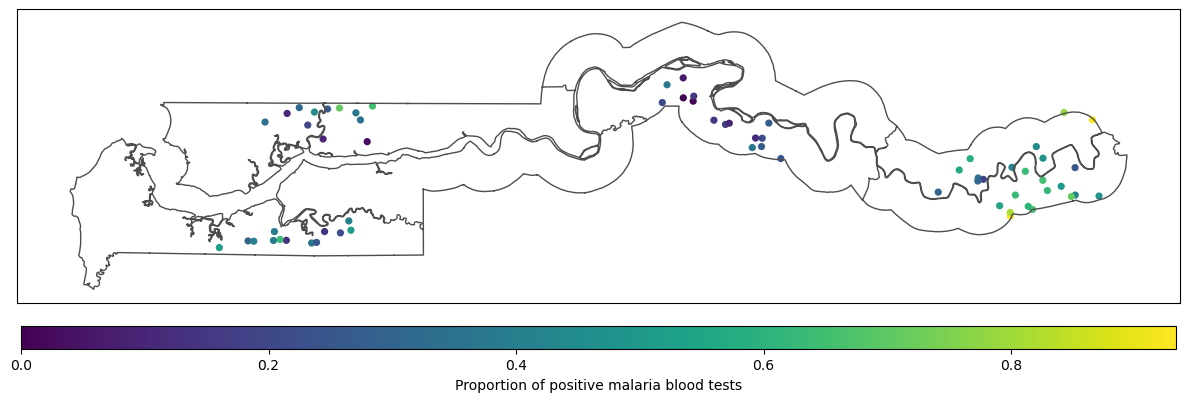

In [4]:
df_borders = pl.read_csv("gambia_borders.csv")

df_avg = (
    df.group_by("location")
    .agg(pl.col("pos").mean(), pl.col("x").first(), pl.col("y").first())
)

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_borders["x"], df_borders["y"], color="0.3", lw=1)
points = ax.scatter(df_avg["x"], df_avg["y"], s=17.5, c=df_avg["pos"], cmap="viridis")

fig.colorbar(
    points,
    label="Proportion of positive malaria blood tests",
    ax=ax,
    pad=0.05,
    fraction=0.05,
    aspect=50,
    orientation="horizontal",
)
ax.set(xticks=[], yticks=[], aspect="equal");

In [5]:
def pl_scale(name):
    return (pl.col(name) - pl.col(name).mean()) / pl.col(name).std()

X_geo_std_unique = (
    df.select("x", "y", "location")
    .with_columns(x_std=pl_scale("x"), y_std=pl_scale("y"))
    .select("x_std", "y_std").unique(maintain_order=True).to_numpy()
)

print(X_geo_std_unique.shape)
X_geo_std_unique[:5]

(65, 2)


array([[-1.41859375, -1.6756917 ],
       [-1.3288728 , -1.53945099],
       [-1.31110339, -1.54514701],
       [-1.27599142,  0.89837675],
       [-1.24976719, -1.53044334]])

In [6]:
# Compute pairwise squared distances
diff = X_geo_std_unique[:, None, :] - X_geo_std_unique[None, :, :] # shape (L, L, 2)
dist = np.sqrt(np.sum(diff**2, axis=-1))   # shape (L, L)
dist.shape

(65, 65)

## The model in the paper

### Model description

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\text{logit}(\pi_i) = \eta_i &= \alpha + {\bf X}_i\boldsymbol\beta+\gamma_{g[i]} \\
\alpha &\sim \text{Normal}(\mu_0, \tau_0^2) \\
\boldsymbol{\beta} &\sim \text{Normal}(0, \frac{1}{5} \phi_1 W \mathbf{I})  \\
\boldsymbol{\gamma} &\sim \text{Normal}(0, \phi_2 W \mathbf{C}) \\
\rho &\sim \text{Uniform}(0, 2r) \\
W &\sim \text{GBP}(a^*, b^*, c^*, d^*) \\
(\phi_1, \phi_2) &\sim \text{Dirichlet}(\xi_1, \xi_2)
\end{aligned}
$$

we assume

$$
\begin{aligned}
\mathbb{E}(\gamma_i) &= 0 & \text{for all } i  \\
\mathbb{V}(\gamma_i) &= \sigma^2_\gamma & \text{for all } i \\
C_{ij} &= \text{Cor}(\gamma_i, \gamma_j) = e^{-d_{ij} / \rho} & \text{for all } i \ne j  \\
\end{aligned}
$$

where $d_{ij}$ is the distance between village $i$ and $j$, and $\rho > 0$ is the spatial range parameter.

* $\mu_0 = 0$
* $\tau_0^2 = 3$
* $\xi_1 = \xi_2 = 1$
* $r$ is the maximum distance between pairs of villages.

In [7]:
family = LogisticFamily(a=1, b=1, intercept=special.logit(df.get_column("pos").mean()))
params = WGBP(family)
params

array([1.36752202, 0.61766941, 0.82137832, 1.79821958])

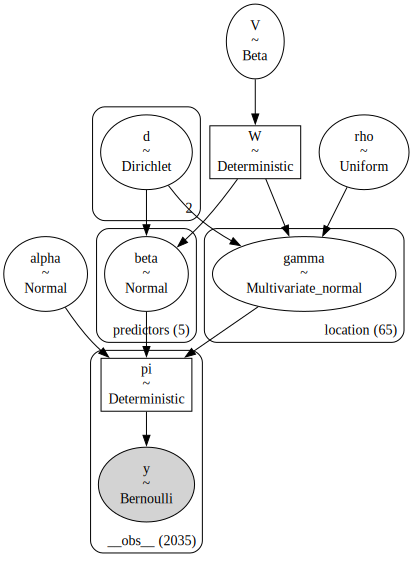

In [8]:
y = df.get_column("pos").to_numpy()
X = df.select("age", "netuse", "treated", "green", "phc").to_numpy()
X_std = (X - X.mean(0)) / X.std(0)
location_idx = df.get_column("location").to_numpy()

# NOTE: why does the case study say 0.986?
r = dist.max()                    # Maximum distance
p = X.shape[1]                    # Number of predictors
coords = {
    "__obs__": np.arange(len(y)),
    "predictors": ["age", "netuse", "treated", "green", "phc"],
    "location": np.unique(location_idx)
}

with pm.Model(coords=coords) as model:
    # Correlation matrix
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho)

    V = pm.Beta("V", alpha=params[0], beta=params[1])
    W = pm.Deterministic("W", ((V / (1 - V)) ** (1 / params[2])) * params[3])

    d = pm.Dirichlet("d", a=np.ones(2))

    alpha = pm.Normal("alpha", mu=0, sigma=3 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=((1 / p) * W * d[0]) ** 0.5, dims="predictors")

    gamma = pm.MvNormal("gamma", mu=0, cov=d[1] * W * C, dims="location")

    eta = alpha + X_std @ beta + gamma[location_idx]
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

model.to_graphviz()

In [9]:
with model:
    idata = pm.sample(target_accept=0.9, draws=4000, random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
/home/tomas/miniconda3/envs/pymc-env/lib/python3.13/site-packages/pytensor/link/c/cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, d, alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


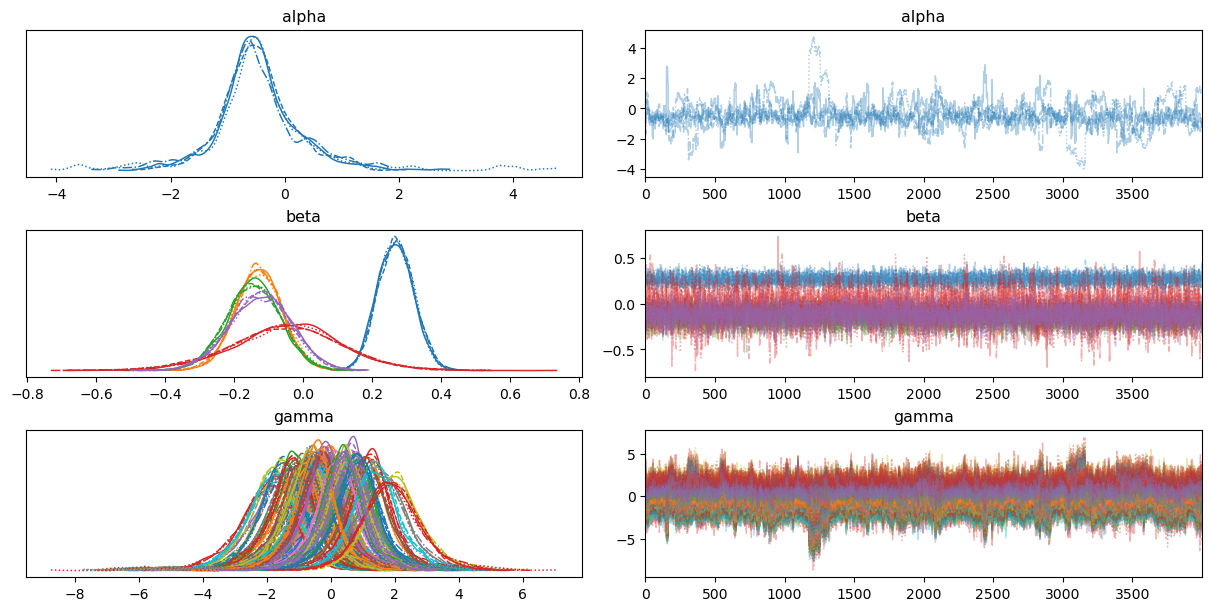

In [10]:
az.plot_trace(idata, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

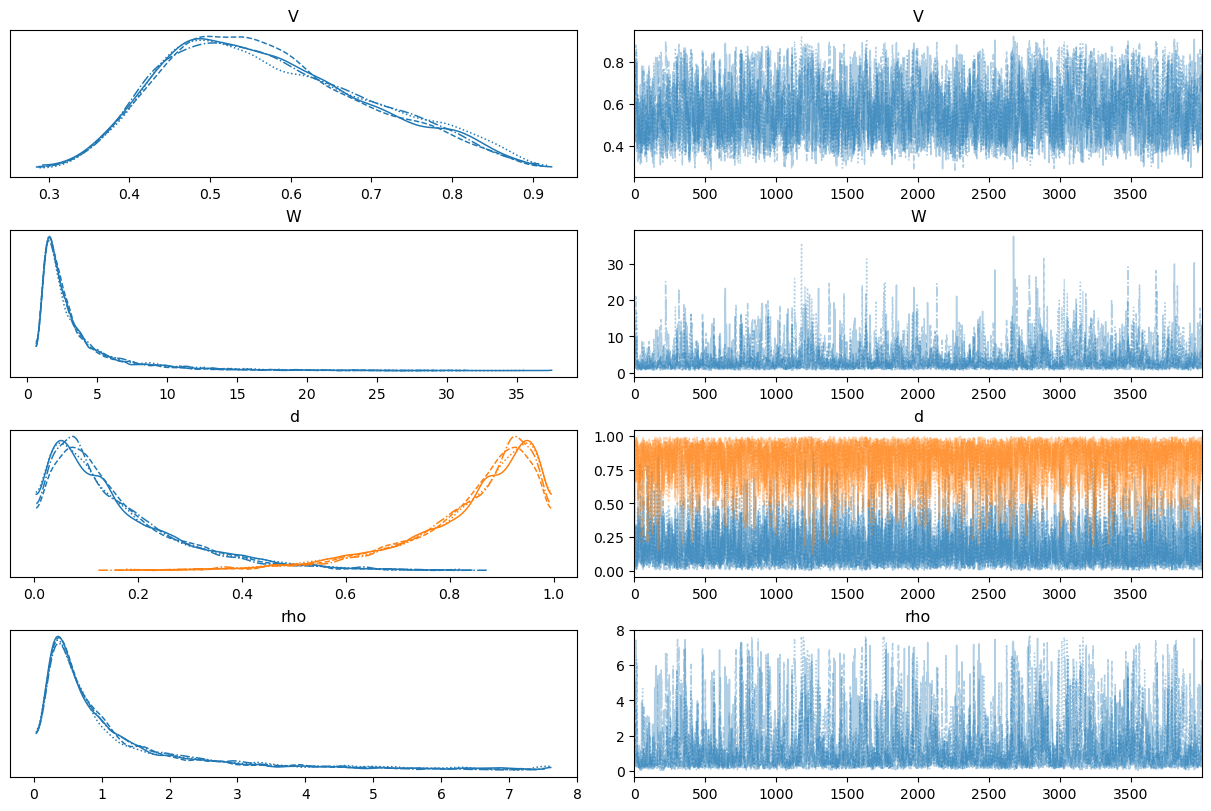

In [12]:
az.plot_trace(idata, var_names=["V", "W", "d", "rho"], backend_kwargs={"layout": "constrained"});

### Problems

Sampling: [V, alpha, beta, d, gamma, rho, y]


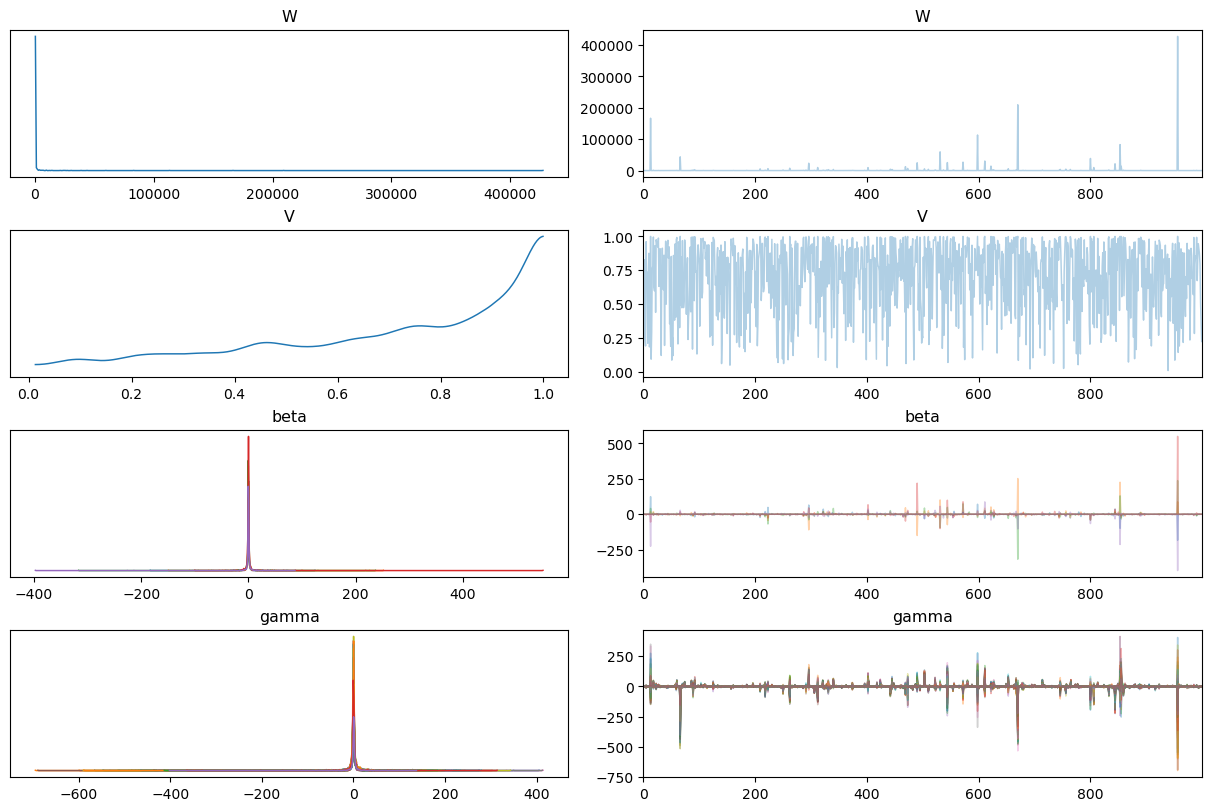

In [13]:
with model:
    idata.extend(pm.sample_prior_predictive(draws=1000))

az.plot_trace(idata.prior, var_names=["W", "V", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

In [14]:
np.sort(xr.corr(idata.posterior.gamma, idata.posterior.alpha, dim=("chain", "draw")))

array([-0.95220108, -0.94835147, -0.94309785, -0.93802749, -0.93443729,
       -0.93290634, -0.92990705, -0.92900007, -0.92859726, -0.92823639,
       -0.92798422, -0.92786087, -0.92266176, -0.92230996, -0.92185871,
       -0.92076629, -0.92062727, -0.9205165 , -0.91895014, -0.91852226,
       -0.9178261 , -0.91745498, -0.91467815, -0.91394068, -0.91296831,
       -0.91293467, -0.91252343, -0.91227221, -0.91008214, -0.90862995,
       -0.90819691, -0.90773414, -0.90506248, -0.90484818, -0.90435003,
       -0.90223466, -0.90192468, -0.90154432, -0.90151147, -0.89915502,
       -0.89598276, -0.89410248, -0.89096647, -0.88995653, -0.88806112,
       -0.88636287, -0.88419364, -0.88395102, -0.88386005, -0.881993  ,
       -0.88175332, -0.8810911 , -0.8793264 , -0.87734267, -0.86540643,
       -0.86168269, -0.85933536, -0.856284  , -0.8521011 , -0.84847545,
       -0.83497718, -0.82392561, -0.80815148, -0.79551536, -0.76744759])

In [15]:
corr_matrix = np.corrcoef(idata.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())
np.linalg.eigvals(corr_matrix)[:5]

array([52.66510786,  2.05953306,  0.54218027,  0.49678191,  0.38596075])

## An alternative proposal

In [16]:
family = LogisticFamily(a=2, b=8, intercept=special.logit(df.get_column("pos").mean()))
params_2= WGBP(family)
params_2

array([3.45220389, 6.72368657, 0.72156864, 2.96020658])

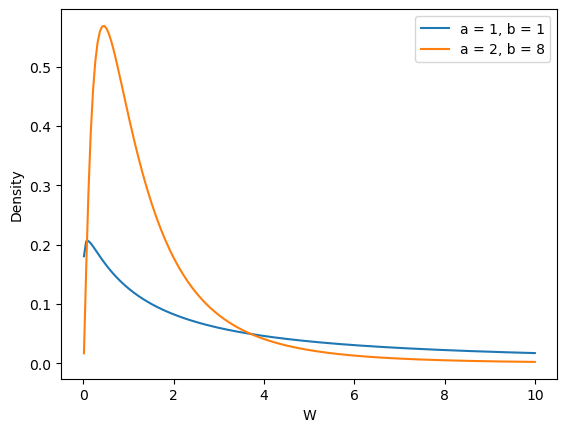

In [17]:
from utils import gbp_pdf

params_dict = {
    "a = 1, b = 1":   params,
    "a = 2, b = 8":   params_2,
    # "a = 1, b = 1":   [1.15, 2.08, 0.91, 2.09],
    # "a = 1, b = 4":   [1.36335635, 2.60432824, 0.81619041, 2.40698754],
    # "a = 0.5, b = 0.5": [0.57, 0.29, 0.90, 1.54],
    # "a = 1, b = 1":   [1.47, 0.65, 0.79, 1.67],
    # "a = 4, b = 4":   [7.45, 2.72, 0.73, 1.63],
    # "a = 4, b = 1":   [7.77, 0.71, 0.68, 1.45],
}

fig, ax = plt.subplots()
x_grid = np.linspace(0.01, 10, num=200)

for key, values in params_dict.items():
    ax.plot(x_grid, gbp_pdf(x_grid, *values), label=key)

ax.set(xlabel="W", ylabel="Density")
ax.legend();

In [18]:
L = len(np.unique(location_idx))

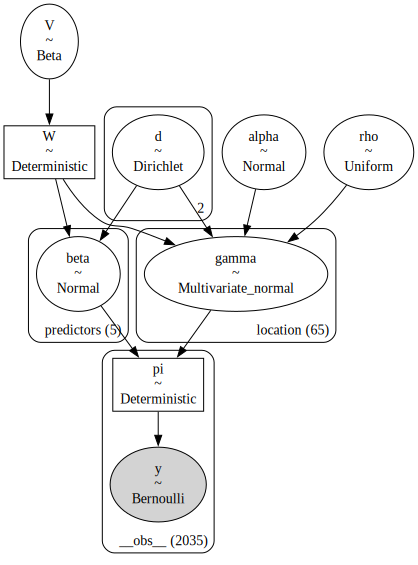

In [19]:
coords = {
    "__obs__": np.arange(len(y)),
    "predictors": ["age", "netuse", "treated", "green", "phc"],
    "location": np.unique(location_idx)
}

with pm.Model(coords=coords) as model_gambia_2:
    # Correlation matrix
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho)

    V = pm.Beta("V", alpha=params_2[0], beta=params_2[1])
    W = pm.Deterministic("W", (V / (1 - V)) ** (1 / params_2[2]) * params_2[3])
    d = pm.Dirichlet("d", a=np.ones(2))

    alpha = pm.Normal("alpha", mu=0, sigma=0.2 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=(1 / p * W * d[0]) ** 0.5, dims="predictors")

    gamma = pm.MvNormal("gamma", mu=alpha, cov=d[1] * W * C, dims="location")

    # eta = alpha + X_std @ beta + gamma[location_idx]
    eta = X_std @ beta + gamma[location_idx]
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

model_gambia_2.to_graphviz()

Sampling: [V, alpha, beta, d, gamma, rho, y]


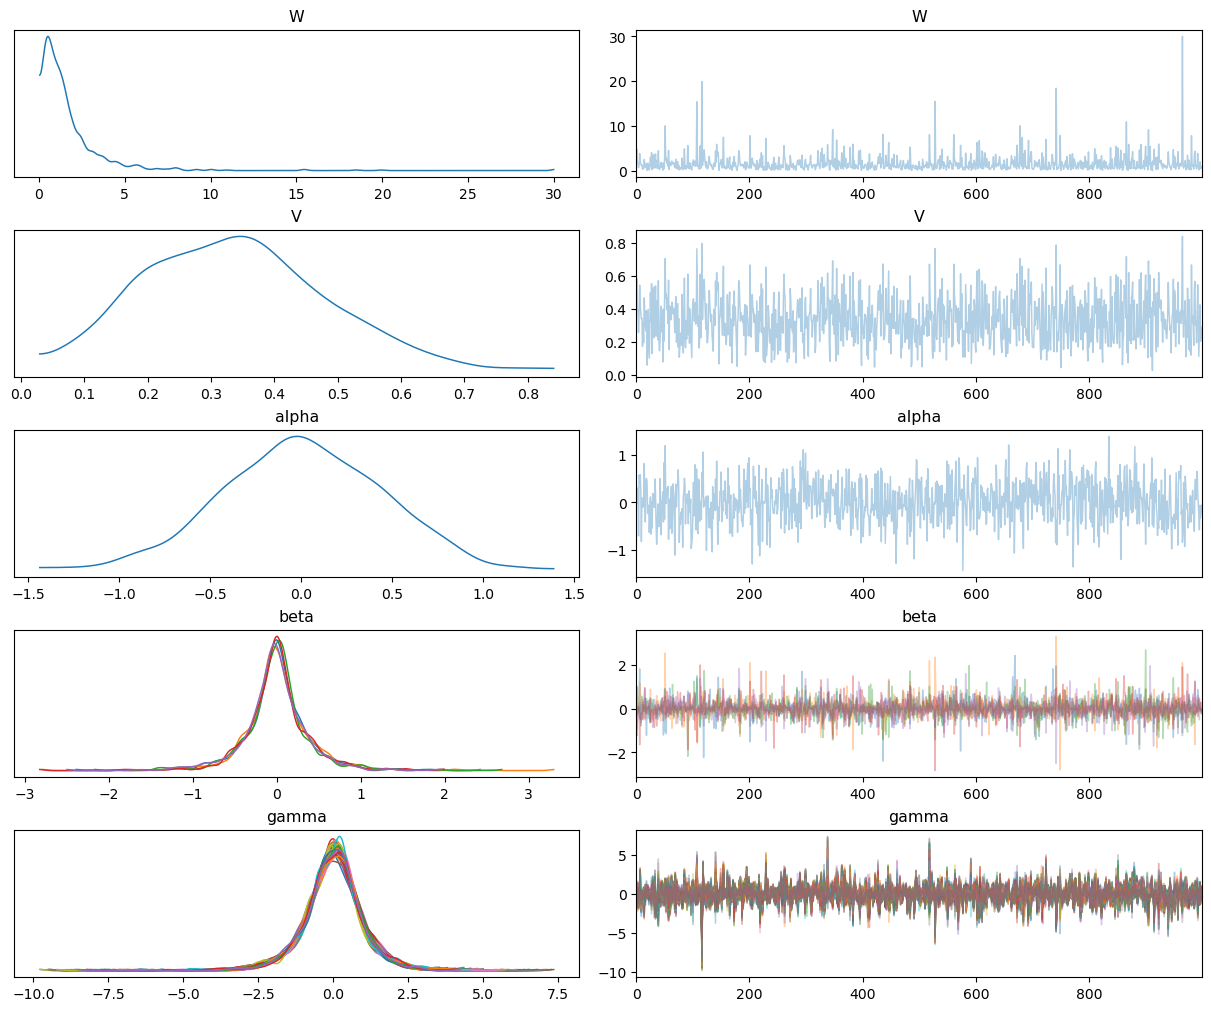

In [27]:
with model_gambia_2:
    idata_gambia_2 = pm.sample_prior_predictive(draws=1000)

az.plot_trace(idata_gambia_2.prior, var_names=["W", "V", "alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

In [ ]:
with model_gambia_2:
    idata_gambia_2.extend(pm.sample(target_accept=0.95, draws=1000, random_seed=random_seed))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, d, alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


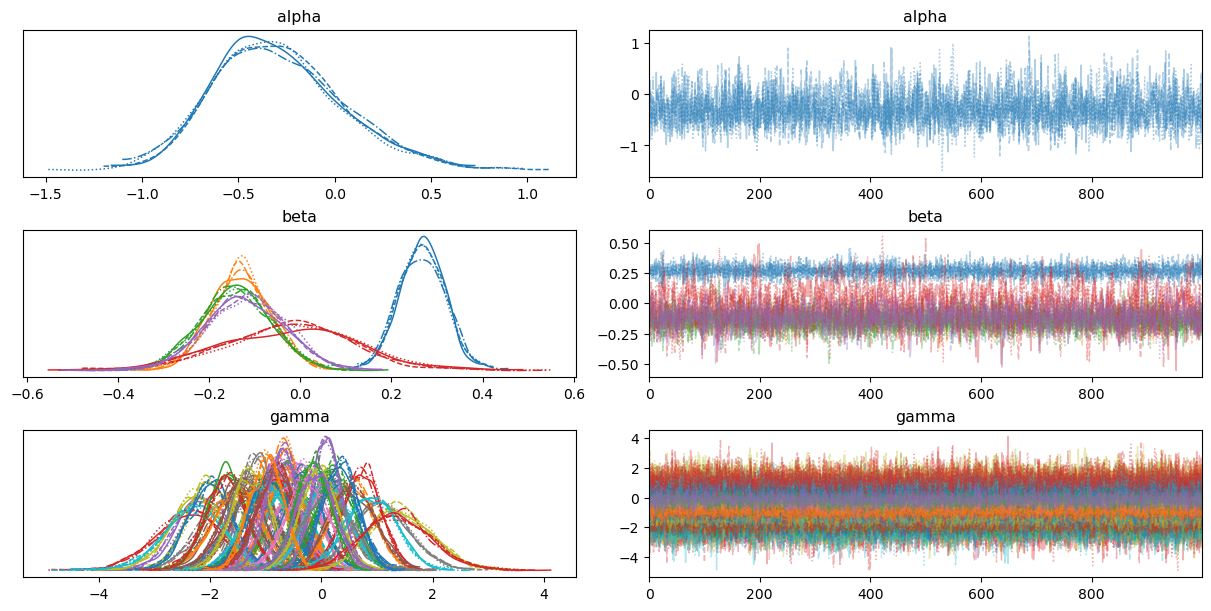

In [21]:
az.plot_trace(idata_gambia_2, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

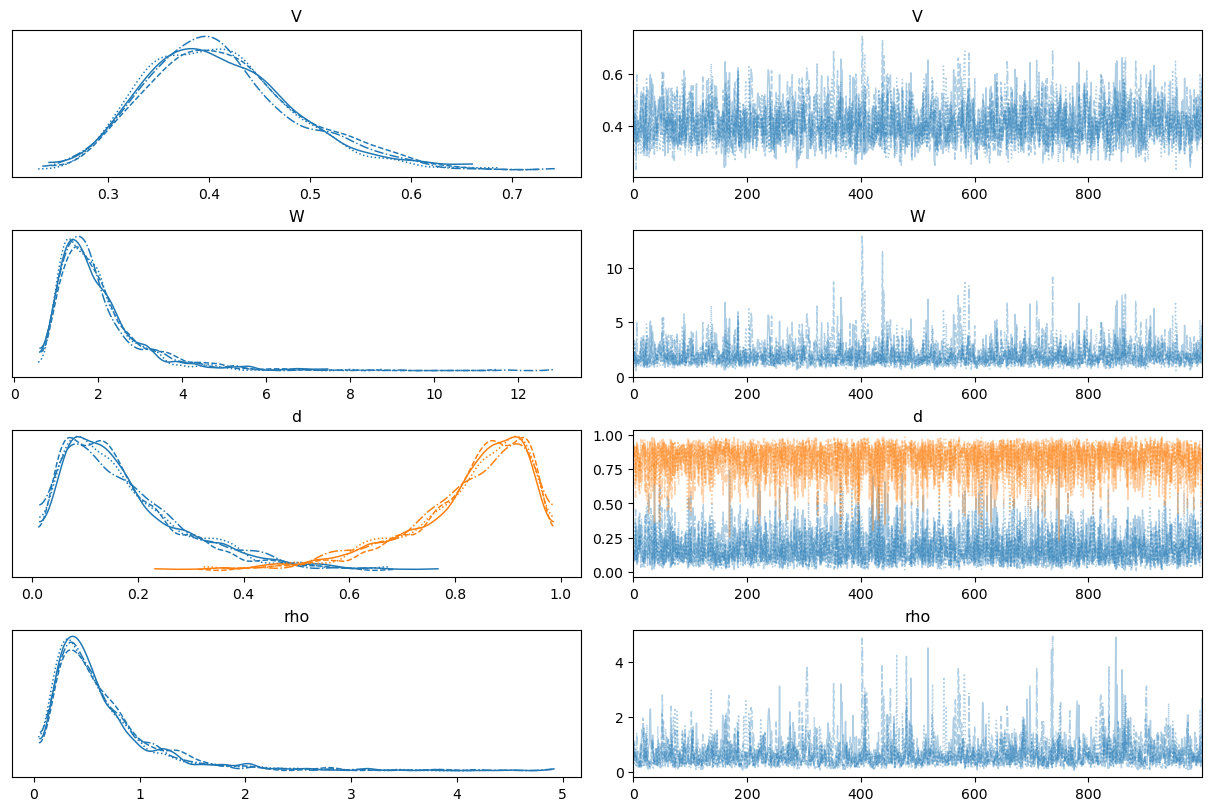

In [22]:
az.plot_trace(idata_gambia_2, var_names=["V", "W", "d", "rho"], backend_kwargs={"layout": "constrained"});

In [23]:
np.sort(xr.corr(idata_gambia_2.posterior.gamma, idata_gambia_2.posterior.alpha, dim=("chain", "draw")))

array([-0.13002589, -0.12123813, -0.08012702, -0.07982326, -0.0771904 ,
       -0.06756011, -0.06681396, -0.06345774, -0.05336462, -0.04859469,
       -0.04761177, -0.04465655, -0.04394771, -0.04113986, -0.03939977,
       -0.03891021, -0.03732664, -0.03654757, -0.0329941 , -0.03296958,
       -0.032883  , -0.03098134, -0.02933477, -0.01903036, -0.01158398,
       -0.01085269, -0.00781292, -0.00581192, -0.00491742, -0.00339752,
       -0.00237217,  0.00077796,  0.00360011,  0.00456323,  0.00541942,
        0.00783436,  0.00938379,  0.00968049,  0.03200747,  0.03413905,
        0.03853052,  0.04258076,  0.04506785,  0.04654295,  0.05557657,
        0.05715257,  0.0606062 ,  0.06298053,  0.06570747,  0.06593863,
        0.07261918,  0.07483774,  0.07511754,  0.07844172,  0.07880588,
        0.08162521,  0.08367369,  0.0886771 ,  0.08901516,  0.09726833,
        0.09869869,  0.10290365,  0.10724015,  0.14734511,  0.15110871])

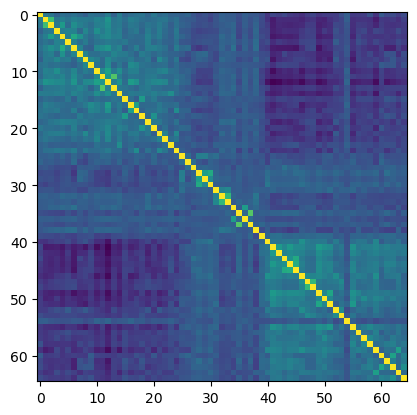

In [24]:
corr_matrix = np.corrcoef(idata_gambia_2.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())

fig, ax = plt.subplots()
ax.imshow(corr_matrix);

In [25]:
np.linalg.eigvals(corr_matrix)

array([9.14618192, 2.43819226, 2.20854422, 1.95341898, 1.70658117,
       1.66099192, 1.56920429, 1.48991797, 1.40462902, 1.35233534,
       1.29250458, 1.25744153, 1.18556544, 1.11554267, 1.10006702,
       1.08347101, 1.06669631, 1.03392927, 0.32265414, 1.00915847,
       0.9924517 , 0.98061304, 0.95787308, 0.95701592, 0.33957387,
       0.35239978, 0.92123613, 0.90626022, 0.88670543, 0.87494882,
       0.83042922, 0.81472225, 0.81258753, 0.80069524, 0.79591351,
       0.40489032, 0.41751072, 0.42538242, 0.44159097, 0.45352403,
       0.45963391, 0.47997921, 0.48877508, 0.50314963, 0.51339258,
       0.5208043 , 0.75583746, 0.74539601, 0.73824805, 0.72757484,
       0.54234242, 0.56117611, 0.56816511, 0.57392483, 0.58527071,
       0.59489532, 0.60838877, 0.69656581, 0.68401797, 0.6786321 ,
       0.62688543, 0.63765419, 0.63493275, 0.65239571, 0.65860998])

In [ ]:
# from utils import gbp_pdf

# params2 = [1.4722786, 0.6494361, 0.7887448, 1.6711417]

# params_dict = {
#     # "a = 1, b = 4":   [1.15, 2.08, 0.91, 2.09],
#     # "a = 1, b = 4":   [1.36335635, 2.60432824, 0.81619041, 2.40698754],
#     "a = 2, b = 8":   params,
#     # "a = 0.5, b = 0.5": [0.57, 0.29, 0.90, 1.54],
#     "a = 1, b = 1":   [1.47, 0.65, 0.79, 1.67],
#     "a = 4, b = 4":   [7.45, 2.72, 0.73, 1.63],
#     "a = 4, b = 1":   [7.77, 0.71, 0.68, 1.45],
# }

# fig, ax = plt.subplots()
# x_grid = np.linspace(0.01, 10, num=200)

# for key, values in params_dict.items():
#     ax.plot(x_grid, gbp_pdf(x_grid, *values), label=key)

# ax.legend();

In [ ]:
# NOTE: Why does the paper don't do (1 / L)?

# L = len(np.unique(location_idx))  # Number of villages

In [ ]:
# 2, 8 for WGBP